In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-speech-commands/LICENSE
/kaggle/input/google-speech-commands/testing_list.txt
/kaggle/input/google-speech-commands/README.md
/kaggle/input/google-speech-commands/validation_list.txt
/kaggle/input/google-speech-commands/no/97f4c236_nohash_3.wav
/kaggle/input/google-speech-commands/no/6f3458b3_nohash_1.wav
/kaggle/input/google-speech-commands/no/cb2929ce_nohash_3.wav
/kaggle/input/google-speech-commands/no/ad63d93c_nohash_1.wav
/kaggle/input/google-speech-commands/no/aeb99b1c_nohash_1.wav
/kaggle/input/google-speech-commands/no/c08585c1_nohash_4.wav
/kaggle/input/google-speech-commands/no/9d32f10a_nohash_0.wav
/kaggle/input/google-speech-commands/no/01648c51_nohash_1.wav
/kaggle/input/google-speech-commands/no/df1d5024_nohash_2.wav
/kaggle/input/google-speech-commands/no/e0315cf6_nohash_1.wav
/kaggle/input/google-speech-commands/no/28497c5b_nohash_1.wav
/kaggle/input/google-speech-commands/no/c22d3f18_nohash_0.wav
/kaggle/input/google-speech-commands/no/d90b4138_noha

In [4]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.list_physical_devices('GPU'))
tf.config.experimental.set_memory_growth(physical_devices[0], True)   

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install tensorflow --upgrade

# My Information

* Name: Ahmed Gamal Ahmed Mohamed

* ID: 20221459969

* Dept.: Intelligent Systems

* Level: 4

* ANN Model: Training Accuracy: 0.7911 - Validation Accuracy: 0.7034 (Above 60%)

* Tried CNN Model: Training Accuracy: 0.8799 - Validation Accuracy: 0.7499

* Bonuses Done:
  * Data Normalization
  * Data Augmentation (Background Noise)
  * Model Visualization
  * ANN VS CNN Model
  * MFCC 60 Features

# Importing Libraries

In [86]:
def set_seed(seed=42):
    # Set the random seed for TensorFlow
    tf.random.set_seed(seed)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed for the built-in random module
    random.seed(seed)
    # For ensuring reproducibility on GPUs
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)  # Set your desired seed value here

In [5]:
import os
import shutil
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import pandas as pd
import librosa
import random

# Loading Dataset

In [6]:
# Defining paths
dataset_dir = "/kaggle/input/google-speech-commands"
classes_names = ['zero','one','two','three','four','five','six','seven','eight','nine']
classes_paths = [os.path.join(dataset_dir,x) for x in classes_names]

print(classes_paths)

['/kaggle/input/google-speech-commands/zero', '/kaggle/input/google-speech-commands/one', '/kaggle/input/google-speech-commands/two', '/kaggle/input/google-speech-commands/three', '/kaggle/input/google-speech-commands/four', '/kaggle/input/google-speech-commands/five', '/kaggle/input/google-speech-commands/six', '/kaggle/input/google-speech-commands/seven', '/kaggle/input/google-speech-commands/eight', '/kaggle/input/google-speech-commands/nine']


In [7]:
all_files_names = []  # This is a list to store all the paths of all files in each class
for class_path in classes_paths:
    current_class_files_paths = os.listdir(class_path)
    all_files_names.append(current_class_files_paths)

print(len(all_files_names))
print(len(all_files_names[0]))
#print(all_files_names)

10
2376


In [8]:
classes_files_counts = {}
for class_index, class_all_files_names in enumerate(all_files_names):
    classes_files_counts[class_index] = len(class_all_files_names)
    
for class_index, count in classes_files_counts.items():
    print(f"Number of wav files of class {class_index} = {count}")

Number of wav files of class 0 = 2376
Number of wav files of class 1 = 2370
Number of wav files of class 2 = 2373
Number of wav files of class 3 = 2356
Number of wav files of class 4 = 2372
Number of wav files of class 5 = 2357
Number of wav files of class 6 = 2369
Number of wav files of class 7 = 2377
Number of wav files of class 8 = 2352
Number of wav files of class 9 = 2364


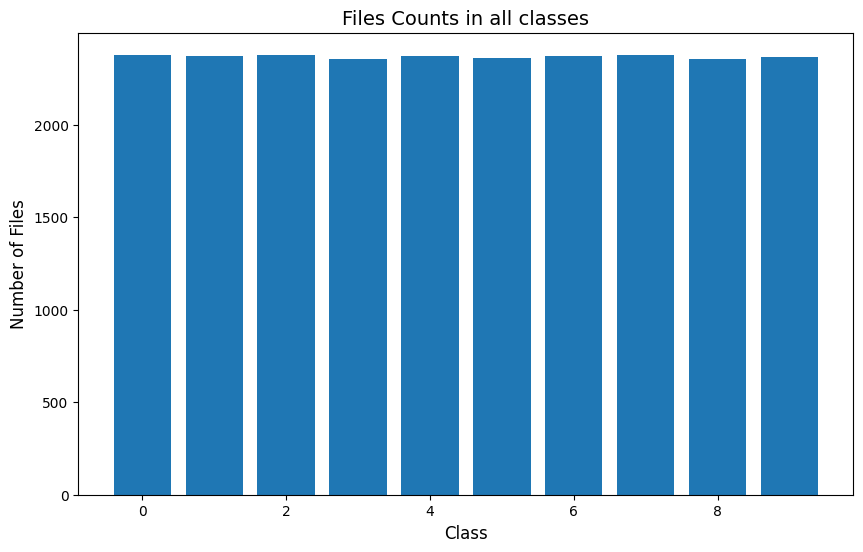

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(classes_files_counts.keys(), classes_files_counts.values())

plt.title('Files Counts in all classes', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Files', fontsize=12)

plt.show()
# This plot shows that we have a balanced dataset

# Reading Audios

In [10]:
full_files_paths = []
classes = []

for class_index, class_files in enumerate(all_files_names):
    for file_name in class_files:
        full_file_path = os.path.join(classes_paths[class_index],file_name)
        full_files_paths.append(full_file_path)
        classes.append(class_index)

print("Number of all dataset files: ", len(full_files_paths))

Number of all dataset files:  23666


In [11]:
audios_data = []
srs_data = []
for file_path in full_files_paths:
    audio, sr = librosa.load(file_path)
    audios_data.append(audio)
    srs_data.append(sr)


# Adding Noise

In [12]:
noise_files_names = os.listdir(os.path.join(dataset_dir,"_background_noise_"))
noise_files_paths = []
for noise_file_name in noise_files_names:
    if noise_file_name.endswith("wav"):
        noise_files_paths.append(os.path.join(dataset_dir,"_background_noise_",noise_file_name))

noise_files_paths
    

['/kaggle/input/google-speech-commands/_background_noise_/exercise_bike.wav',
 '/kaggle/input/google-speech-commands/_background_noise_/pink_noise.wav',
 '/kaggle/input/google-speech-commands/_background_noise_/running_tap.wav',
 '/kaggle/input/google-speech-commands/_background_noise_/white_noise.wav',
 '/kaggle/input/google-speech-commands/_background_noise_/doing_the_dishes.wav',
 '/kaggle/input/google-speech-commands/_background_noise_/dude_miaowing.wav']

In [13]:
# Function to add noise to an audio sample
def add_noise(audio, noise, snr):
    # Adjust the noise level based on the desired signal-to-noise ratio (SNR)
    audio_power = np.sum(audio ** 2) / len(audio)
    noise_power = np.sum(noise ** 2) / len(noise)
    noise_adjusted = noise * np.sqrt(audio_power / (10 ** (snr / 10) * noise_power))
    
    # Mix the noise with the original audio
    audio_noisy = audio + noise_adjusted[:len(audio)]
    return audio_noisy

In [14]:
noised_data = []
noised_srs = []
noised_data_classes = []
snr_levels = [5, 10, 15]
for index, audio in enumerate(audios_data):
    sr = srs_data[index]
    random_number = random.randint(0, 1) # Used to randomize augmentation (normalization)
    if random_number == 1:
        audio_class = classes[index]
        random_noise_index = random.randint(0,len(noise_files_paths)-1)
        noise_path = noise_files_paths[random_noise_index]
        noise_signal, _ = librosa.load(noise_path, sr=sr)
        
        # Create augmented samples at different SNR levels
        for snr in snr_levels:
            audio_with_noise = add_noise(audio, noise_signal, snr)
            noised_data.append(audio_with_noise)
            noised_data_classes.append(audio_class)
            noised_srs.append(sr)
        

In [15]:
all_audios_data = audios_data + noised_data
all_srs = srs_data + noised_srs
all_classes = classes + noised_data_classes

# Data Normalization

In [16]:
all_audios_normalized = []
for audio in all_audios_data:
    normalized_audio = librosa.util.normalize(audio)
    all_audios_normalized.append(normalized_audio)

# Features Extraction

In [17]:
all_features = []
for index, audio in enumerate(all_audios_normalized):
    sr = all_srs[index]
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=60).T, axis=0)
    all_features.append(mfcc)

print(len(all_features))

59003


In [18]:
X=np.array(all_features) # converts the list to numpy array
y = np.array(all_classes) # converts the list to numpy array

In [19]:
np.save('X', X)
np.save('y', y)

In [20]:
print("X Shape: ",X.shape)
print("y Shape: ",y.shape)

X Shape:  (59003, 60)
y Shape:  (59003,)


In [99]:
X = np.load("X.npy")
y = np.load("y.npy")

In [100]:
print(X)

[[-2.57544708e+02  1.16891136e+02 -8.14946079e+00 ... -1.24238801e+00
  -1.32074523e+00  1.71338543e-01]
 [-3.82883911e+02  6.69154510e+01  1.00617514e+01 ... -1.15605175e+00
  -2.17506599e+00 -1.79394841e+00]
 [-3.75435944e+02  9.59098358e+01  1.20964975e+01 ... -2.32162523e+00
  -1.59795034e+00 -1.04370010e+00]
 ...
 [-6.63057022e+01  7.75679779e+01 -6.56544495e+01 ... -2.45797443e+00
   3.43596363e+00 -4.60368061e+00]
 [-1.01405693e+02  7.63869324e+01 -5.93828964e+01 ... -2.19029593e+00
   3.09287715e+00 -4.20560265e+00]
 [-1.34802155e+02  7.67839661e+01 -5.29811249e+01 ... -1.80167472e+00
   2.95148778e+00 -3.54245758e+00]]


In [101]:
print(y)

[0 0 0 ... 9 9 9]


# Train - Validation - Test Split

In [102]:
# Splitting 20% for validation, 80% For training
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [103]:
print("X_train Shape: ",X_train.shape)
print("y_train Shape: ",y_train.shape)

print("X_val Shape: ",X_val.shape)
print("y_val Shape: ",y_val.shape)


X_train Shape:  (47202, 60)
y_train Shape:  (47202,)
X_val Shape:  (11801, 60)
y_val Shape:  (11801,)


In [104]:
print(X_train[0])

[-144.572        89.67414     -54.24967      50.31573     -34.255146
   37.361565    -31.636812     10.393638    -11.230774     -3.8301694
  -14.248072    -12.03968       4.653463    -10.959716     10.581908
   -9.450639      4.1928964   -11.367321      5.4729505    -6.477156
   -4.9035373    -2.0277727    -6.1956162     5.384335     -4.0489626
    7.7530575    -0.93364406    6.0190125    -3.381355      2.2669108
   -3.278877     -2.1422033     2.7972555    -2.8325975     3.4775038
   -3.6993606     3.3280244    -1.572948      5.0840836    -0.19133078
    2.1163673     0.63027006   -1.3499216     1.0169911    -3.9000738
    2.8060157    -3.2406135     1.3091588    -1.046158      1.0358846
   -1.4615477    -0.5825533    -1.7530193    -4.118227     -1.4957111
   -4.9961905    -1.2358989    -4.791199     -1.1430062    -3.8470514 ]


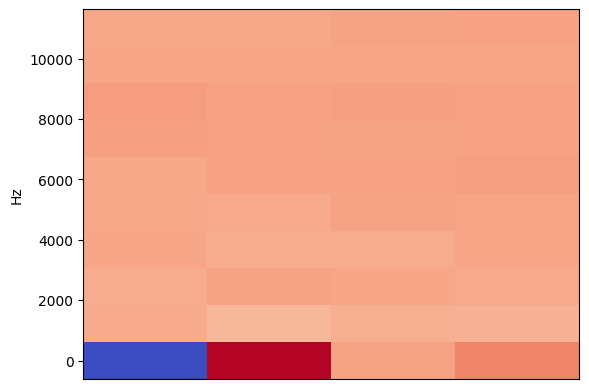

In [77]:
librosa.display.specshow(X_train[0], y_axis='linear')

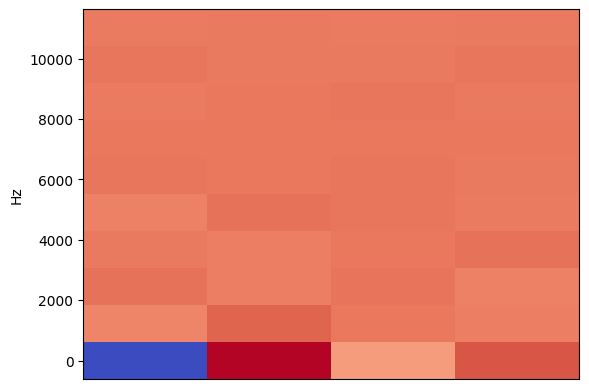

In [78]:
librosa.display.specshow(X_train[len(X_train)-1], y_axis='linear')

In [105]:
# Convert target labels to one-hot encoded format
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

In [106]:
print("X_train Shape: ",X_train.shape)
print("y_train Shape: ",y_train.shape)

print("X_val Shape: ",X_val.shape)
print("y_val Shape: ",y_val.shape)


X_train Shape:  (47202, 60)
y_train Shape:  (47202, 10)
X_val Shape:  (11801, 60)
y_val Shape:  (11801, 10)


In [107]:
print(y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# ANN Model

In [108]:
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers

model = Sequential([
    # layers.Reshape(INPUTSHAPE, input_shape=(40)),
    
    layers.Dense(512, activation='relu', input_shape=(60,)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)               │ (None, 512)            │        31,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 886,858 (3.38 MB)

 Trainable params: 886,858 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
batch_size = 64
from tensorflow.keras.preprocessing.image import ImageDataGenerator   
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, verbose=1, mode='auto',
    restore_best_weights=True)

# Define learning rate reduction callback
lr_reduction_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='auto',
    min_lr=1e-8  # Set a minimum learning rate
)

history = model.fit(X_train,y_train ,validation_data=(X_val,y_val),
            epochs=40,
            callbacks = [callback,lr_reduction_callback],batch_size=batch_size)


Epoch 1/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.1034 - loss: 2.3097 - val_accuracy: 0.1644 - val_loss: 2.1967 - learning_rate: 0.0010
Epoch 2/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.1877 - loss: 2.0866 - val_accuracy: 0.2652 - val_loss: 1.9114 - learning_rate: 0.0010
Epoch 3/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2670 - loss: 1.9094 - val_accuracy: 0.2515 - val_loss: 1.9680 - learning_rate: 0.0010
Epoch 4/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2784 - loss: 1.8872 - val_accuracy: 0.3012 - val_loss: 1.8379 - learning_rate: 0.0010
Epoch 5/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3083 - loss: 1.8209 - val_accuracy: 0.2985 - val_loss: 1.8327 - learning_rate: 0.0010
Epoch 6/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3271 - loss: 1.7740 - val_accuracy: 0.3646 - val_loss: 1.7120 - learning_rate: 0.0010
Epoch 7/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3614 - loss: 1.7076

In [111]:
history2 = model.fit(X_train,y_train ,validation_data=(X_val,y_val),
            epochs=40,
            callbacks = [callback,lr_reduction_callback],batch_size=batch_size)

Epoch 1/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7323 - loss: 0.8388 - val_accuracy: 0.6791 - val_loss: 1.0346 - learning_rate: 2.5000e-04
Epoch 2/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7349 - loss: 0.8319 - val_accuracy: 0.6565 - val_loss: 1.0820 - learning_rate: 2.5000e-04
Epoch 3/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7330 - loss: 0.8446 - val_accuracy: 0.6798 - val_loss: 1.0434 - learning_rate: 2.5000e-04
Epoch 4/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7419 - loss: 0.8173 - val_accuracy: 0.6764 - val_loss: 1.0403 - learning_rate: 2.5000e-04
Epoch 5/40
729/738 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7392 - loss: 0.8165
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7392 - loss: 0.8164 - val_accuracy: 0.6798 - val_loss: 1.0409 - learning_rate: 2.5000e-04
Epoch 6/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.751

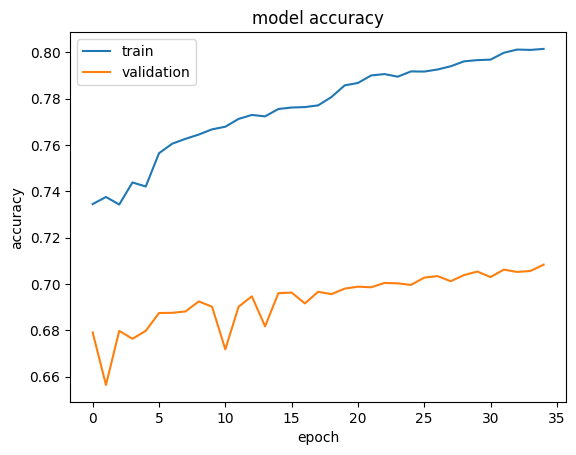

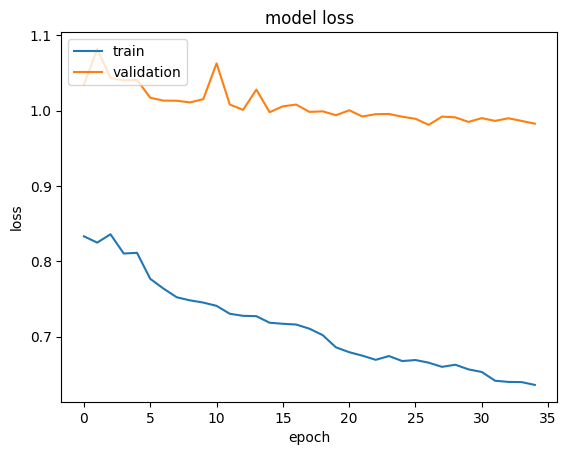

In [112]:
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# CNN Model

In [113]:
X_train=np.reshape(X_train,(X_train.shape[0],10,6,1))

X_val=np.reshape(X_val,(X_val.shape[0],10,6,1))


In [114]:
print("X_train Shape: ",X_train.shape)
print("y_train Shape: ",y_train.shape)

print("X_val Shape: ",X_val.shape)
print("y_val Shape: ",y_val.shape)


X_train Shape:  (47202, 10, 6, 1)
y_train Shape:  (47202, 10)
X_val Shape:  (11801, 10, 6, 1)
y_val Shape:  (11801, 10)


In [134]:
INPUTSHAPE = (10, 6, 1)  # Adjusted input shape

model = Sequential([
    layers.Reshape(INPUTSHAPE, input_shape=(10, 6, 1)),  # Adjust input shape
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(strides=(1,1)),
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(strides=(1,1)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_14 (Reshape)            │ (None, 10, 6, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 10, 6, 128)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 10, 6, 128)     │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 10, 6, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 9, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 9, 5, 128)      │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 9, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 9, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 9, 5, 128)      │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 9, 5, 128)      │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 9, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 8, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 8, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 8, 4, 128)      │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 8, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 8, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,873,066 (10.96 MB)

 Trainable params: 2,871,018 (10.95 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [135]:
# CNN Code
batch_size = 64
from tensorflow.keras.preprocessing.image import ImageDataGenerator   
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, verbose=1, mode='auto',
    restore_best_weights=True)

# Define learning rate reduction callback
lr_reduction_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto',
    min_lr=1e-9  # Set a minimum learning rate
)

history = model.fit(X_train,y_train ,validation_data=(X_val,y_val),
            epochs=40,
            callbacks = [callback,lr_reduction_callback],batch_size=batch_size)


Epoch 1/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.1412 - loss: 2.2248 - val_accuracy: 0.2328 - val_loss: 1.9283 - learning_rate: 0.0010
Epoch 2/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2551 - loss: 1.9206 - val_accuracy: 0.3406 - val_loss: 1.7920 - learning_rate: 0.0010
Epoch 3/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3624 - loss: 1.7360 - val_accuracy: 0.4304 - val_loss: 1.5971 - learning_rate: 0.0010
Epoch 4/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4063 - loss: 1.6540 - val_accuracy: 0.4350 - val_loss: 1.6010 - learning_rate: 0.0010
Epoch 5/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4413 - loss: 1.5856 - val_accuracy: 0.4669 - val_loss: 1.5147 - learning_rate: 0.0010
Epoch 6/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4651 - loss: 1.5266 - val_accuracy: 0.4895 - val_loss: 1.4772 - learning_rate: 0.0010
Epoch 7/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4801 - loss: 1.4984 

In [131]:
history2 = model.fit(X_train,y_train ,validation_data=(X_val,y_val),
            epochs=40,
            callbacks = [callback,lr_reduction_callback],batch_size=batch_size)


Epoch 1/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8378 - loss: 0.4798 - val_accuracy: 0.7305 - val_loss: 0.9616 - learning_rate: 2.5000e-04
Epoch 2/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8628 - loss: 0.3924 - val_accuracy: 0.7426 - val_loss: 0.9524 - learning_rate: 2.5000e-04
Epoch 3/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8786 - loss: 0.3512 - val_accuracy: 0.7392 - val_loss: 1.0064 - learning_rate: 2.5000e-04
Epoch 4/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8856 - loss: 0.3343 - val_accuracy: 0.7475 - val_loss: 0.9981 - learning_rate: 2.5000e-04
Epoch 5/40
731/738 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8967 - loss: 0.2952
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8968 - loss: 0.2949 - val_accuracy: 0.7479 - val_loss: 1.0044 - learning_rate: 2.5000e-04
Epoch 6/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.906

In [132]:
history3 = model.fit(X_train,y_train ,validation_data=(X_val,y_val),
            epochs=40,
            callbacks = [callback,lr_reduction_callback],batch_size=batch_size)


Epoch 1/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8799 - loss: 0.3448 - val_accuracy: 0.7499 - val_loss: 0.9468 - learning_rate: 6.2500e-05
Epoch 2/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8901 - loss: 0.3207 - val_accuracy: 0.7526 - val_loss: 0.9524 - learning_rate: 6.2500e-05
Epoch 3/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8943 - loss: 0.3056 - val_accuracy: 0.7531 - val_loss: 0.9702 - learning_rate: 6.2500e-05
Epoch 4/40
731/738 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8976 - loss: 0.2949
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8977 - loss: 0.2946 - val_accuracy: 0.7553 - val_loss: 0.9820 - learning_rate: 6.2500e-05
Epoch 5/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9033 - loss: 0.2800 - val_accuracy: 0.7564 - val_loss: 0.9745 - learning_rate: 3.1250e-05
Epoch 6/40
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.907

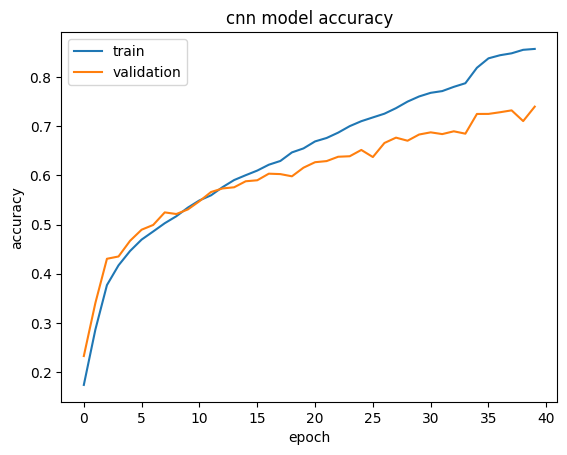

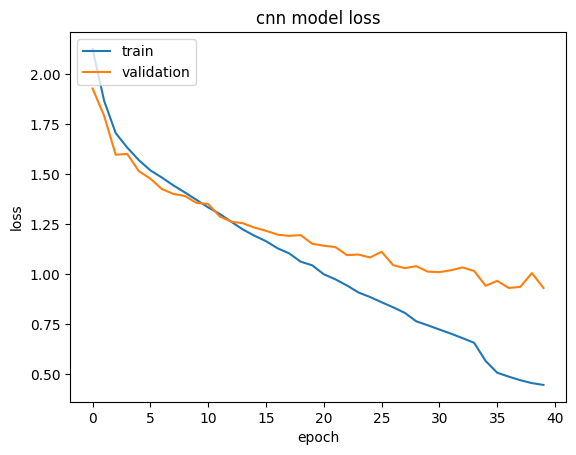

In [137]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('cnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('cnn model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()